### Data loading

Data can come in the form  of almost anthing. common forms are:
- Excel
- Images
- videos
- text
- audio


We are going to use Linear Regresion formula to make a straight line with *known* parameters. 

A parameter is something that a model learns.

Weight is the the(b)
bias is the (y)

in Y = mx + b

In [20]:
# Create *known* parameters

import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

weight = 0.7
bias = 0.3

# Create Data

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) #input
y = weight * X + bias #output

X[:10], y[:10], len(X), len(y)


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

Creating a training and test set from out data

In [21]:
len(X), len(y)


(50, 50)

In [22]:
#Create a train/test split

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]


len(X_train), len(y_train), len(X_test), len(y_test)


(40, 40, 10, 10)

To visualize our data we can use matplot

In [23]:
def plot_predicitions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None,
):
    plt.figure(figsize=(10, 7))

    # Plt training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # plot test data in green

    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # Are there predictions?

    if predictions is not None:
        # plot predictions
        plt.scatter(test_data, predictions, c="r", s=4, label="Predicitions")
    #Show the legend
    plt.legend(prop={"size": 14});


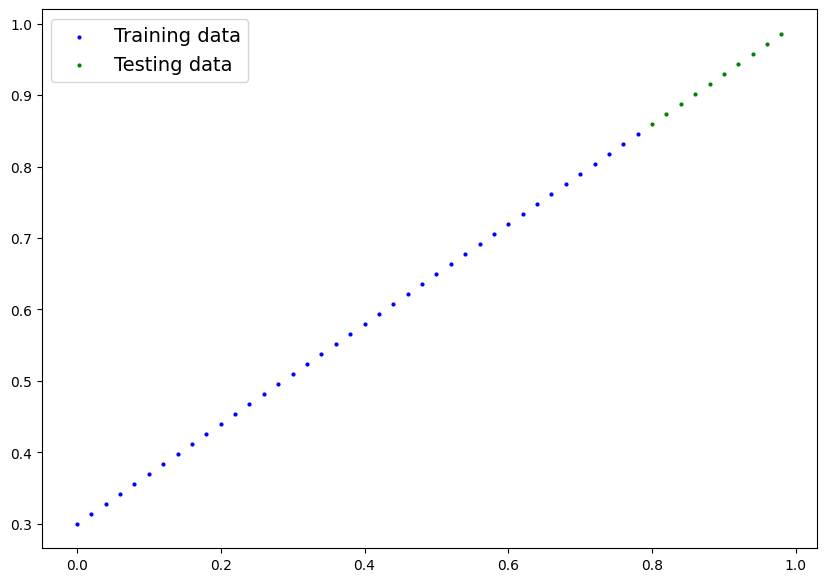

In [24]:
plot_predicitions()


What does the model do?

- Start with random values (weight and bias)
- look at training data and adjust the random values to better represent(or get closer to) the ideal values (the weight and bias) values we used to create the data

How does it do this?

Through two main algorithms:
1. gradient descent
2. backpropagation

gradient descent is why we need to use `requires_grad=True`


In [25]:
# Build model using a linear regression model

#Create linear regression model class

class LinearRegessionModel(nn.Module): #<- pytorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        # requires_grad is optional if the param requires gradient
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    # Forward method to define the computation method in the model
    # any class that is a subclass of nn.module REQUIRES a forward method
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias #linear regression formula


### PyTorch model building essentials

- torch.nn - contains all the buildins for computational graphs
- torch.nn.Parameter - what parameters should our model try and learn, often a pytorch layer from torch.nn will set these for us
- torch.nn.Module = The base class for all neural network modules, if you sublass it, you should overwrite forward()
- torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent
- def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation


In [26]:
# Create a random seed

torch.manual_seed(42) #if we comment this out we get different values every time

# Create an instance of the model (this is a subclass of nn.Module)

model_0 = LinearRegessionModel()

# Check out the params
list(model_0.parameters())


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [27]:
# List named parameters

model_0.state_dict()


OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [28]:
weight, bias


(0.7, 0.3)

# Making predicitions using torch.inference_mode() 
To check preditive power of model, we can test it on `y_test` based on `x_test`

When we pass data through our model, it is going to run it through the forward() method

In [29]:
#Making predicitions using torch.inference_mode()

with torch.inference_mode(): # This removes the grad func to add context
    y_preds = model_0(X_test)

y_preds


tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [30]:
y_test


tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

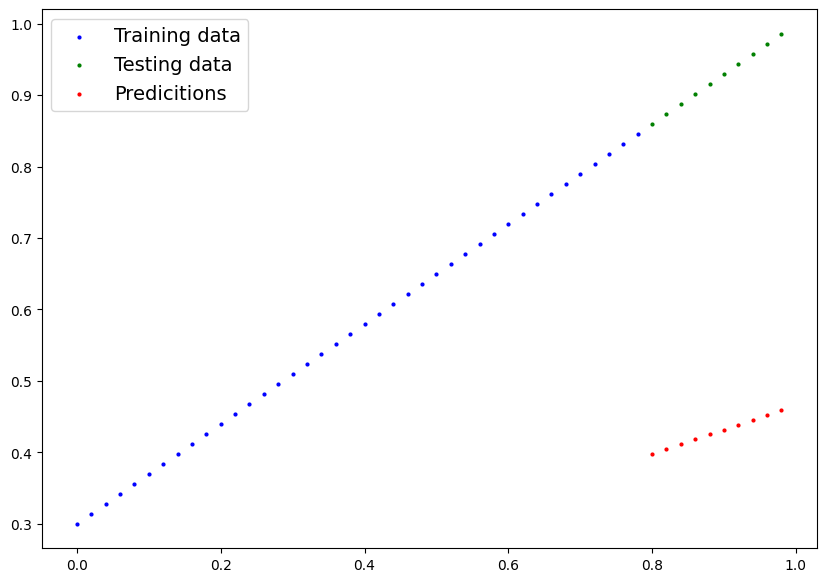

In [31]:
plot_predicitions(predictions=y_preds)


## Train model

The whole idea for training is for model to move from some unknown parameters (these may be random) to some known params

or in other words a poor representation to a better representation of our data. In the output above, this is a pretty poor representation as the red dots are far off from the green dots.

We can use a loss function to determine how poor/wrong model predicitions are.

Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

**A Loss function:** A function to measure how wrong your model's predictions are compared to our ideal output. The lower the number,the better

**Optimizer**: Takes into account the loss of a model and adjusts the model's parameters (eg: weight and bias)

Specifically for PyTorch, we need:

- A training loop
- A testing loop


The loss function we want to use from PyTorch for *this* model is a Mean Absolute Error (MAE).

```py
MAE_loss = torch.mean(torch.abs(y_pred-y_test))
#or
MAE_loss = torch.nn.L1loss #recommended
```

The optimizer we are going to use for *this* model is the stochastic gradient descent (SGD). This is used with random numbers to test which gets closer to ideal, based on the loss function (it adjusts model params with random numbers to reduce loss)

Learning Rate: possibly the most important hyper param you can set. The default the docs use is 0.01. The smaller the learning rate, the smaller the step towards the ideal

In [32]:
# Setup a loss function

loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
#lr -> learning rate
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

optimizer


SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### Building a training loop (and a testing loop) in PyTorch

to build a training loop:

0. Loop through the data and do...
1. Forward pass (this involved data moving through our model's forward() function/s) to make predicitions on data- also called forward propagation
2. Calculate the loss (compare forward pass predicitions to ground truth labels)
3. Otpimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**Backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

Steps 4 and 5 drive most of our learning

In [33]:
epochs = 175 # one time through all the data (this is a hyper param because we set it ourself)

#Tracking
epoch_count = []
loss_values = []
test_loss_values = []


#training
# 0. loop through the data -> Memorize step 1 - 5
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

    # 1. forward pass
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    # print(f"Loss: {loss}")
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to params of model
    loss.backward()

    # 5. step the optimizer (perform gradient descent)
    optimizer.step() # by default how the optimizer changes will accumlate through the loop... so we have to zero them above in step 3 for the next iteration in the loop

    # Testing
    model_0.eval() # Turns off gradient tracking
    with torch.inference_mode(): #turns off gradient tracking and a couple more things behind the scenes
        test_pred = model_0(X_test)

        test_loss = loss_fn(test_pred, y_test)
        #print out what is happening
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            loss_values.append(loss)
            test_loss_values.append(test_loss)
            print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
            print(model_0.state_dict())




 #print out model state_dict()
model_0.state_dict()


Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

In [34]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)


In [35]:
weight, bias


(0.7, 0.3)

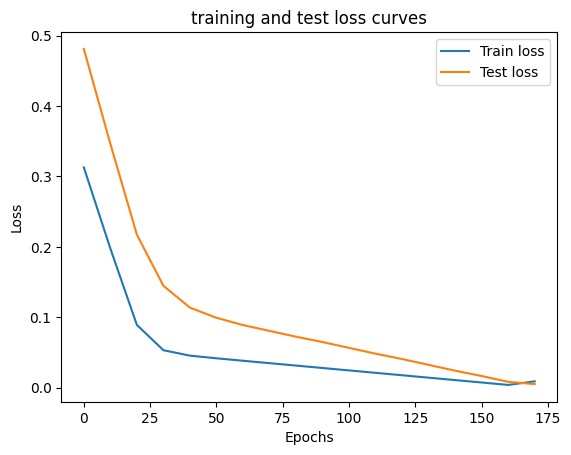

In [36]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()


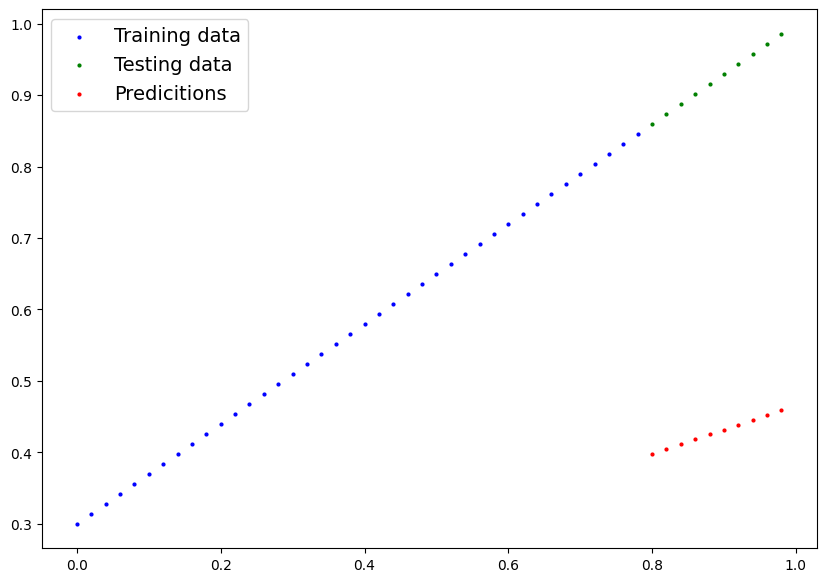

In [37]:
plot_predicitions(predictions=y_preds)


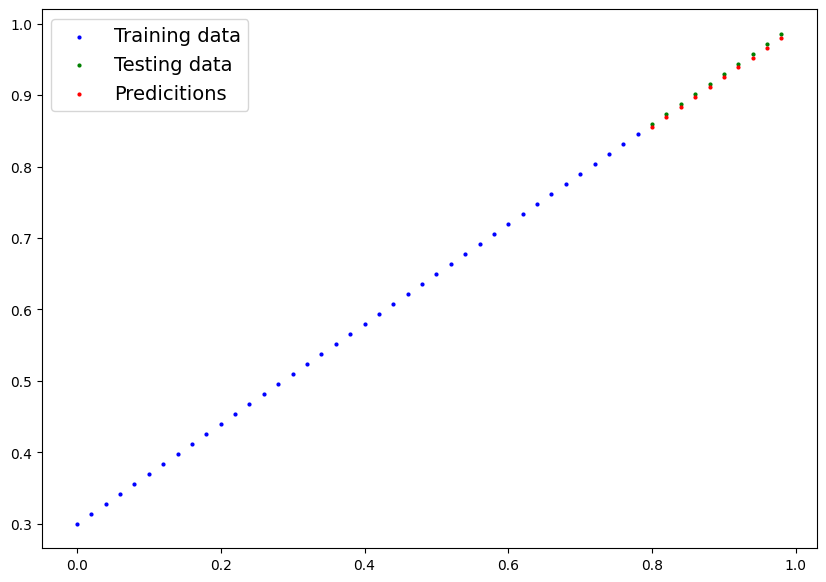

In [38]:
plot_predicitions(predictions=y_preds_new)
